## Problem Statement

The primary problem to address is to gain comprehensive insights into the demographics of anime fans and industry trends and to develop a effective item-based recommendation system for animes.

In [43]:
# Importing necessary libraries following PEP 8 guidelines

# Basic Libraries
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import warnings
from wordcloud import WordCloud

# Data Preprocessing
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA

# Clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# Model Training
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Collaborative Filtering
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Content-Based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# Hypothesis Testing
from scipy import stats

# GUI Modules
import tkinter as tk
from tkinter import messagebox
from tkhtmlview import HTMLLabel

# Setting display options for pandas
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# Ignoring warnings
warnings.filterwarnings(action='ignore')

# Setting plot style
plt.style.use('ggplot')

%matplotlib inline

In [44]:
# Importing Data
user_data = pd.read_csv('users_cleaned.csv', low_memory=False)
anime_data = pd.read_csv('anime_cleaned.csv', low_memory=False)
anime_list = pd.read_csv('animelists_cleaned.csv', low_memory=False)

# Extracting relevant columns from user ratings
user_rating = anime_list[['username', 'anime_id', 'my_score', 'my_status']]

# Merging anime data with user ratings
anime_rating = anime_data.merge(user_rating, on='anime_id')


## Dataset Description 
anime_cleaned.csv: This file provides detailed information on individual anime, including title, synonyms, genre, studio, licensor, producer, duration, rating, score, airing date, episodes, source (manga, light novel, etc.), and various other relevant data. The dataset covers 14,478 unique anime, offering substantial insights into trends over time.

users_cleaned.csv: Focusing on users who watch anime, this file contains essential demographic data such as username, registration date, last online date, birth date, gender, location, and aggregated values from their anime lists. With 302,675 unique users, it enables a thorough analysis of user behavior and preferences.

animelist_cleaned.csv: Detailing anime lists for all users, this file includes information on the username, anime ID, score, status, and the timestamp when the record was last updated. With 80,076,112 records, including 46,358,322 with ratings, it forms the basis for understanding user engagement with anime titles.



In [45]:
# Displaying the different types of animes in the dataset
# Load the example tips dataset
tips = px.data.tips()

# Create a histogram for anime types
fig = px.histogram(anime_data, y="type", orientation="h")
fig.update_xaxes(categoryorder='total ascending', title="Types of Anime")

# Show the plot
fig.show()


In [46]:
# Displaying the number of animes aired through the years
fig = px.histogram(anime_data, x="aired_from_year", 
                   title='Number of Animes Aired Through the Years')

# Show the plot
fig.show()


In [47]:
# Creating a scatter plot for Anime Score vs. Number of Scores
fig = px.scatter(anime_data, x='score', y='scored_by', 
                 labels={'score': 'Overall Score', 'scored_by': 'Number of Scores'}, 
                 title='Anime Score vs. Number of Scores')

# Show the plot
fig.show()


In [48]:
# Creating a histogram for Anime Scores vs. Count of Scores
fig = px.histogram(anime_data, x="score", 
                   title='Anime Scores vs. Count of Scores')

# Show the plot
fig.show()


In [49]:
# Extracting mean rating per user
MRPU = user_data[['username', 'user_id', 'stats_mean_score']]

# Merging mean ratings with anime list
anime_with_mean_ratings = anime_list.merge(MRPU, on='username')

# Selecting relevant columns
anime_with_mean_ratings = anime_with_mean_ratings[['username', 'anime_id', 'user_id', 
                                                   'my_score', 'stats_mean_score']]

# Merging with anime data
anime_with_mean_ratings = anime_with_mean_ratings.merge(anime_data, how='left', on='anime_id')

# Selecting final relevant columns
anime_with_mean_ratings = anime_with_mean_ratings[['username', 'anime_id', 'user_id', 
                                                   'my_score', 'stats_mean_score', 'title', 'genre']]


In [50]:
# Creating a cross-tabulation of user IDs and anime titles
cross_tab = pd.crosstab(anime_with_mean_ratings['user_id'], 
                        anime_with_mean_ratings['title'])


In [51]:
# Performing PCA on the cross-tabulated data
pca = PCA(n_components=3)
pca.fit(cross_tab)
pca_crosstab = pca.transform(cross_tab)

# Creating a DataFrame for the PCA results
cluster = pd.DataFrame(pca_crosstab)

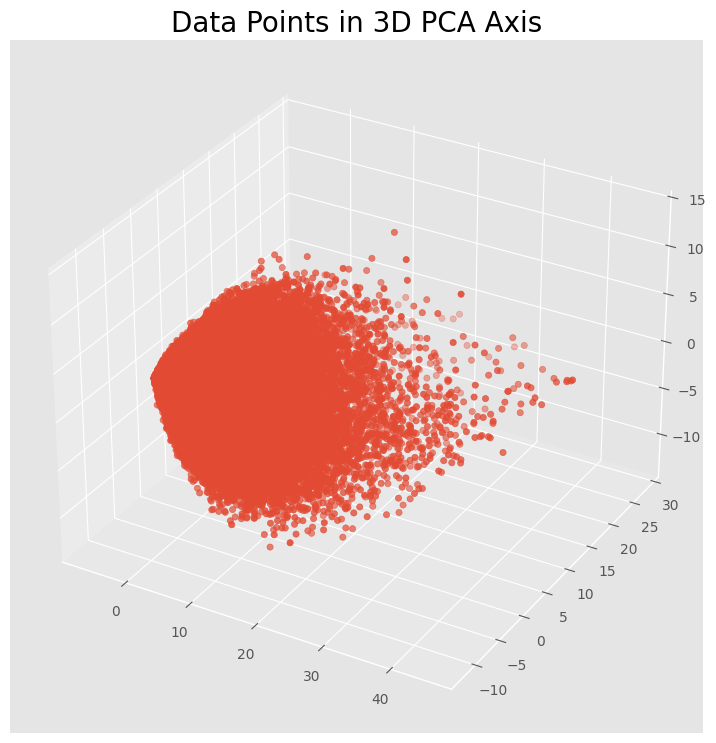

In [52]:
# Setting the figure size for the plot
plt.rcParams['figure.figsize'] = (16, 9)

# Creating a 3D scatter plot for the PCA results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster[0], cluster[1], cluster[2])

# Setting the plot title
plt.title('Data Points in 3D PCA Axis', fontsize=20)

# Showing the plot
plt.show()

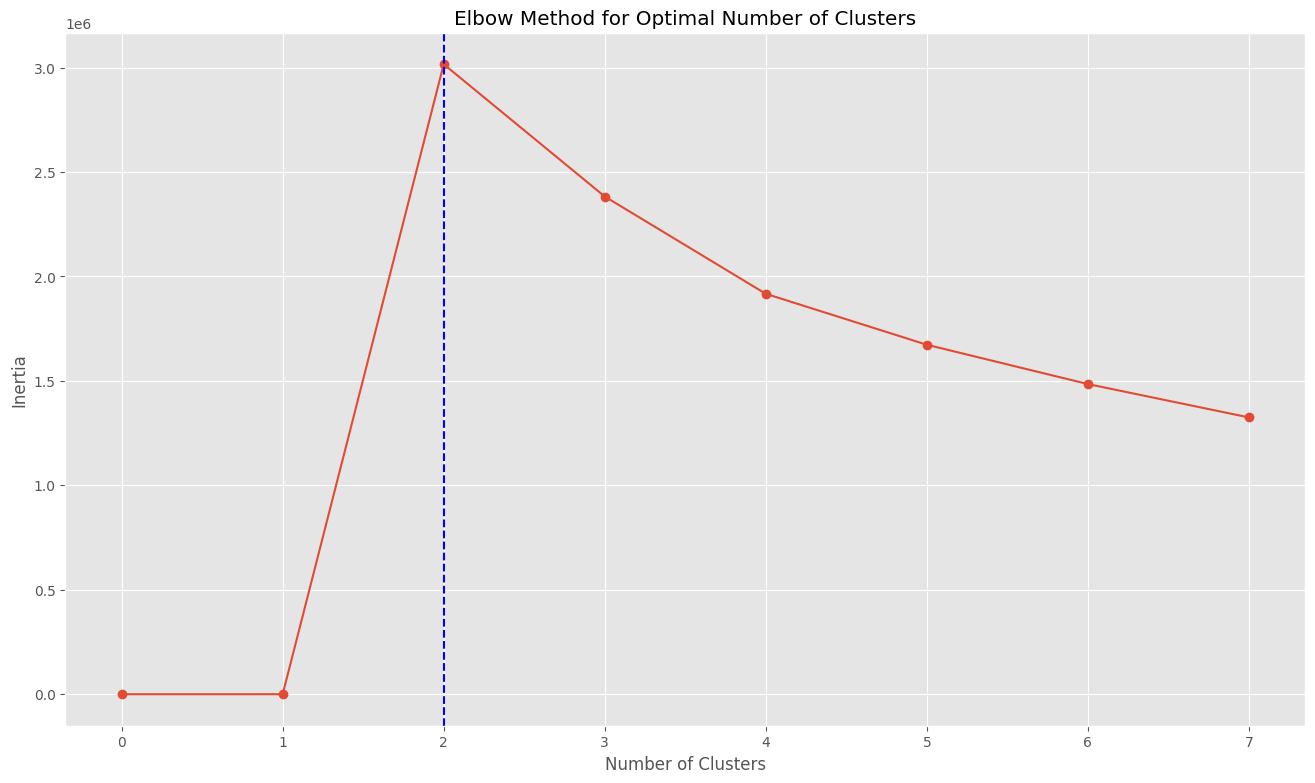

In [53]:
# Initializing lists to store scores and inertia values
scores = []
inertia_list = np.empty(8)

# Performing KMeans clustering for a range of cluster numbers
for i in range(2, 8):
    kmeans = KMeans(n_clusters=i, random_state=42)  # Setting a random state for reproducibility
    kmeans.fit(cluster)
    inertia_list[i] = kmeans.inertia_
    scores.append(silhouette_score(cluster, kmeans.labels_))

# Plotting the inertia values to determine the optimal number of clusters
plt.plot(range(0, 8), inertia_list, '-o')
plt.xlabel('Number of Clusters')
plt.axvline(x=2, color='blue', linestyle='--')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal Number of Clusters')
plt.show()

Based on the "inertia graph", we can see the elbow point is 2 clusters, so we will divide the dataset into 2 clusters of users.

In [54]:
# Performing KMeans clustering with 2 clusters
clusterer = KMeans(n_clusters=2, random_state=272)
clusterer.fit(cluster)

# Extracting the cluster centers
centers = clusterer.cluster_centers_

# Predicting the cluster for each data point
c_preds = clusterer.predict(cluster)

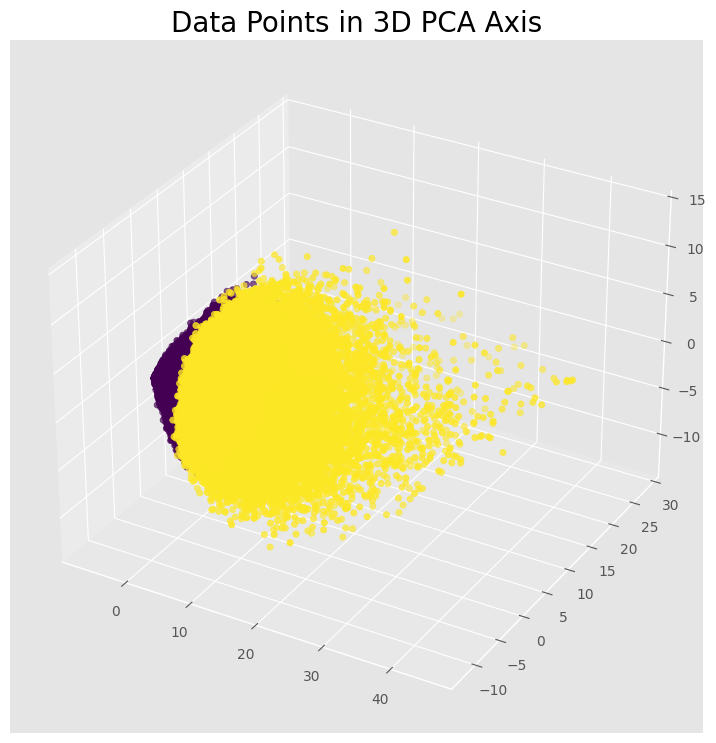

In [55]:
# Setting the figure size for the plot
plt.rcParams['figure.figsize'] = (16, 9)

# Creating a 3D scatter plot for the PCA results with cluster predictions
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(cluster[0], cluster[1], cluster[2], c=c_preds, cmap='viridis')

# Setting the plot title
plt.title('Data Points in 3D PCA Axis', fontsize=20)

# Showing the plot
plt.show()

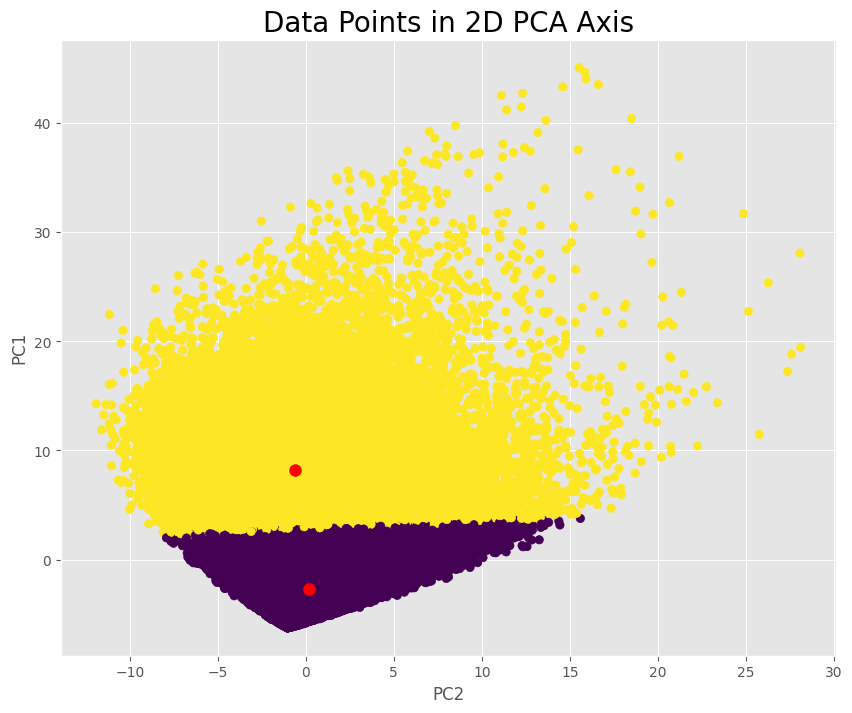

In [56]:
# Creating a 2D scatter plot for the PCA results with cluster predictions
fig = plt.figure(figsize=(10, 8))
plt.scatter(cluster[1], cluster[0], c=c_preds, cmap='viridis')

# Plotting the cluster centers
for ci, c in enumerate(centers):
    plt.plot(c[1], c[0], 'o', markersize=8, color='red', alpha=1)

# Setting the plot labels and title
plt.xlabel('PC2')
plt.ylabel('PC1')
plt.title('Data Points in 2D PCA Axis', fontsize=20)

# Showing the plot
plt.show()

In [60]:
# Adding 'user_id' and cluster predictions to the cross-tabulated data
cross_tab['user_id'] = cross_tab.index
cross_tab['cluster'] = c_preds

# Merging cluster information with user data
merged_data = user_data.merge(cross_tab[['cluster']], on='user_id', how='left')

# Extracting users belonging to each cluster
cluster_0_users = merged_data[merged_data['cluster'] == 0]
cluster_1_users = merged_data[merged_data['cluster'] == 1]


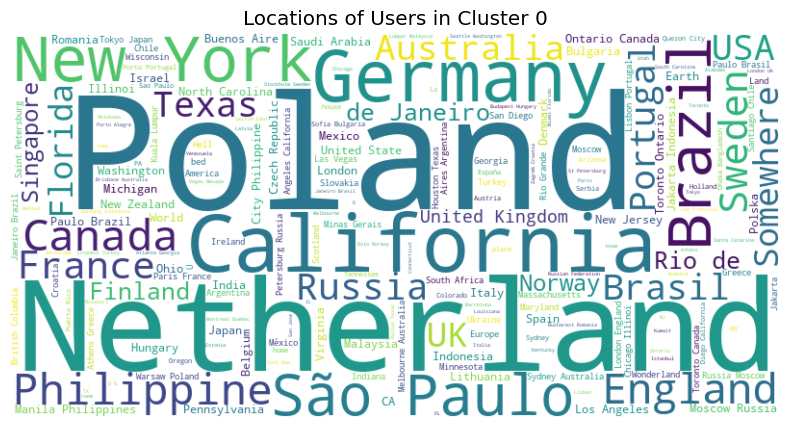

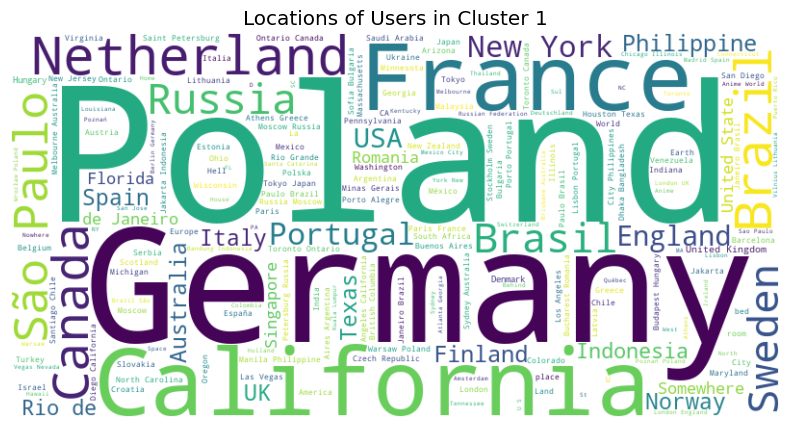

In [61]:
# Import necessary libraries for visualization
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to generate and display a word cloud for a given cluster's user locations
def generate_wordcloud(user_locations, cluster_number):
    # Convert locations to string and combine into a single string
    all_locations = ' '.join(user_locations.astype(str))
    
    # Create a word cloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_locations)
    
    # Display the word cloud
    plt.figure(figsize=(10, 5))
    plt.title(f'Locations of Users in Cluster {cluster_number}')
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

# Generate and display word cloud for cluster 0 users
generate_wordcloud(cluster_0_users['location'], cluster_number=0)

# Generate and display word cloud for cluster 1 users
generate_wordcloud(cluster_1_users['location'], cluster_number=1)


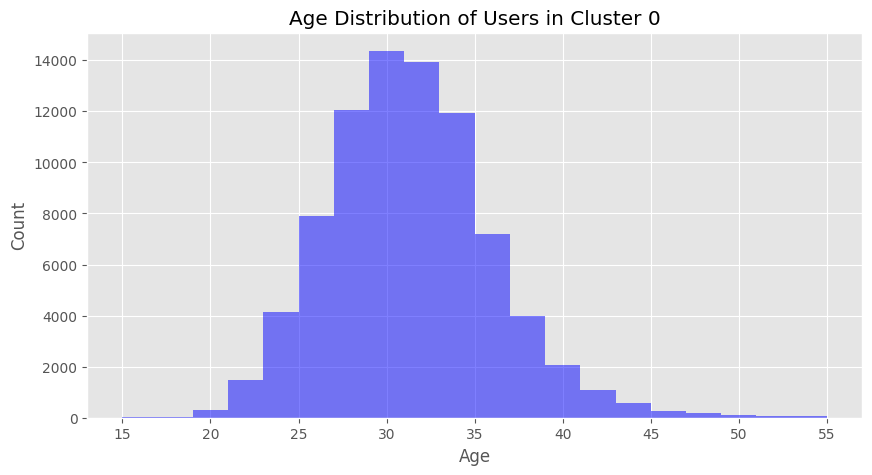

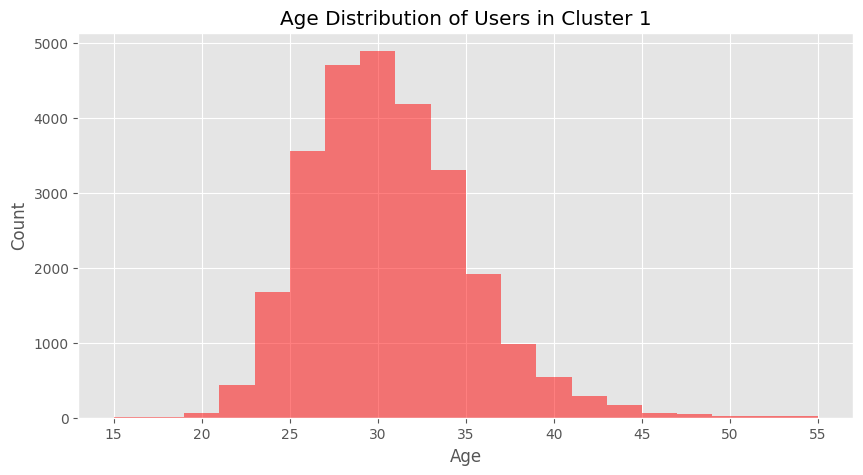

In [62]:
# Function to calculate age from birth date
def calculate_age(birth_date):
    return (pd.Timestamp.now().date() - birth_date.date()).days // 365

# Get the age of users in cluster 0
cluster_0_age = pd.to_datetime(cluster_0_users['birth_date']).apply(calculate_age)

# Get the age of users in cluster 1
cluster_1_age = pd.to_datetime(cluster_1_users['birth_date']).apply(calculate_age)

# Function to plot age distribution for a given cluster
def plot_age_distribution(cluster_age, cluster_number, color):
    plt.figure(figsize=(10, 5))
    plt.hist(cluster_age, bins=20, color=color, alpha=0.5)
    plt.title(f'Age Distribution of Users in Cluster {cluster_number}')
    plt.xlabel('Age')
    plt.ylabel('Count')
    plt.show()

# Plot age distribution for cluster 0
plot_age_distribution(cluster_0_age, cluster_number=0, color='blue')

# Plot age distribution for cluster 1
plot_age_distribution(cluster_1_age, cluster_number=1, color='red')


gender
Male          49802
Female        31634
Non-Binary      326
Name: count, dtype: int64


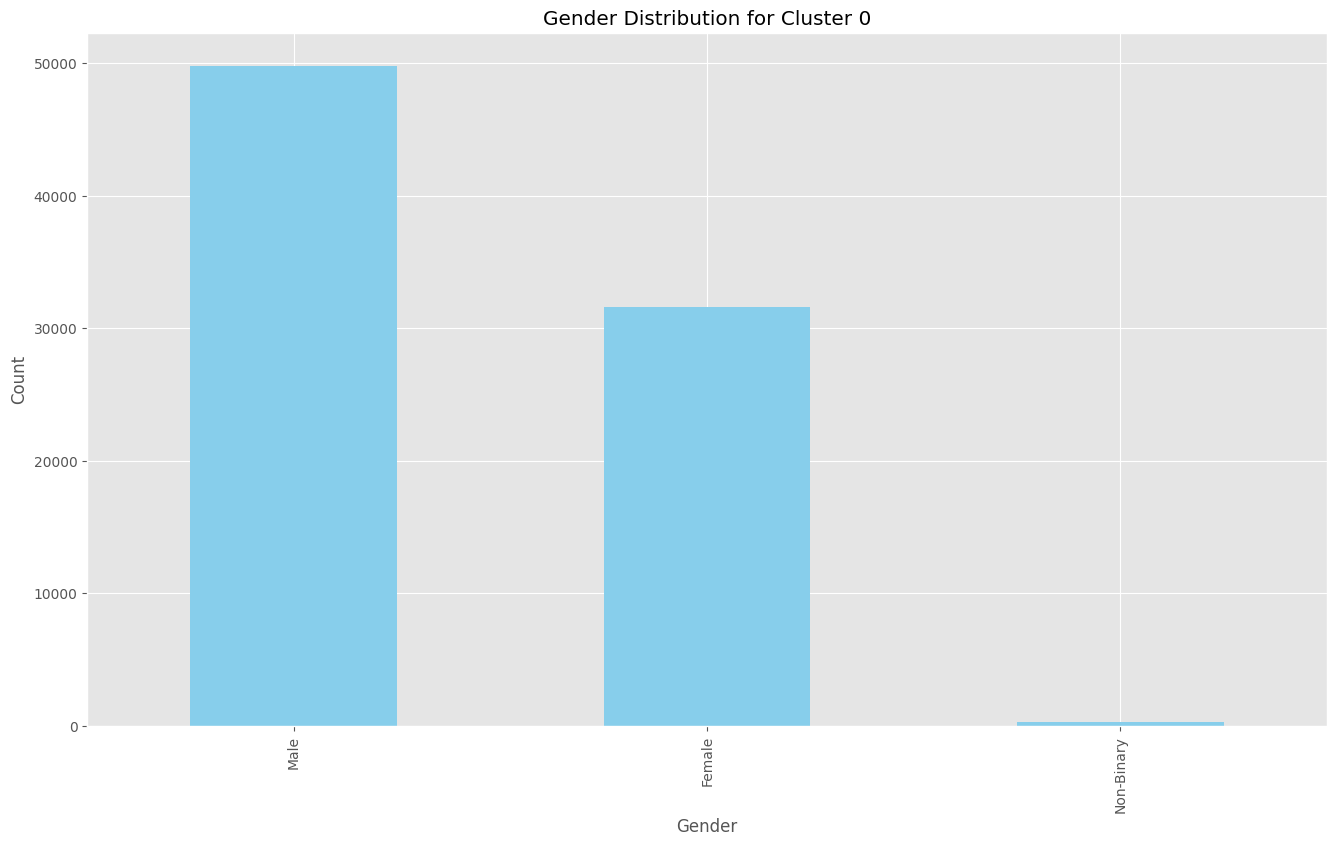

In [64]:
# Calculate gender distribution for cluster 0
gender_distribution_cluster_0 = cluster_0_users['gender'].value_counts()
print(gender_distribution_cluster_0)

# Plot gender distribution for cluster 0
gender_distribution_cluster_0.plot(kind='bar', color='skyblue')
plt.title('Gender Distribution for Cluster 0')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

gender
Male          21077
Female         5696
Non-Binary      175
Name: count, dtype: int64


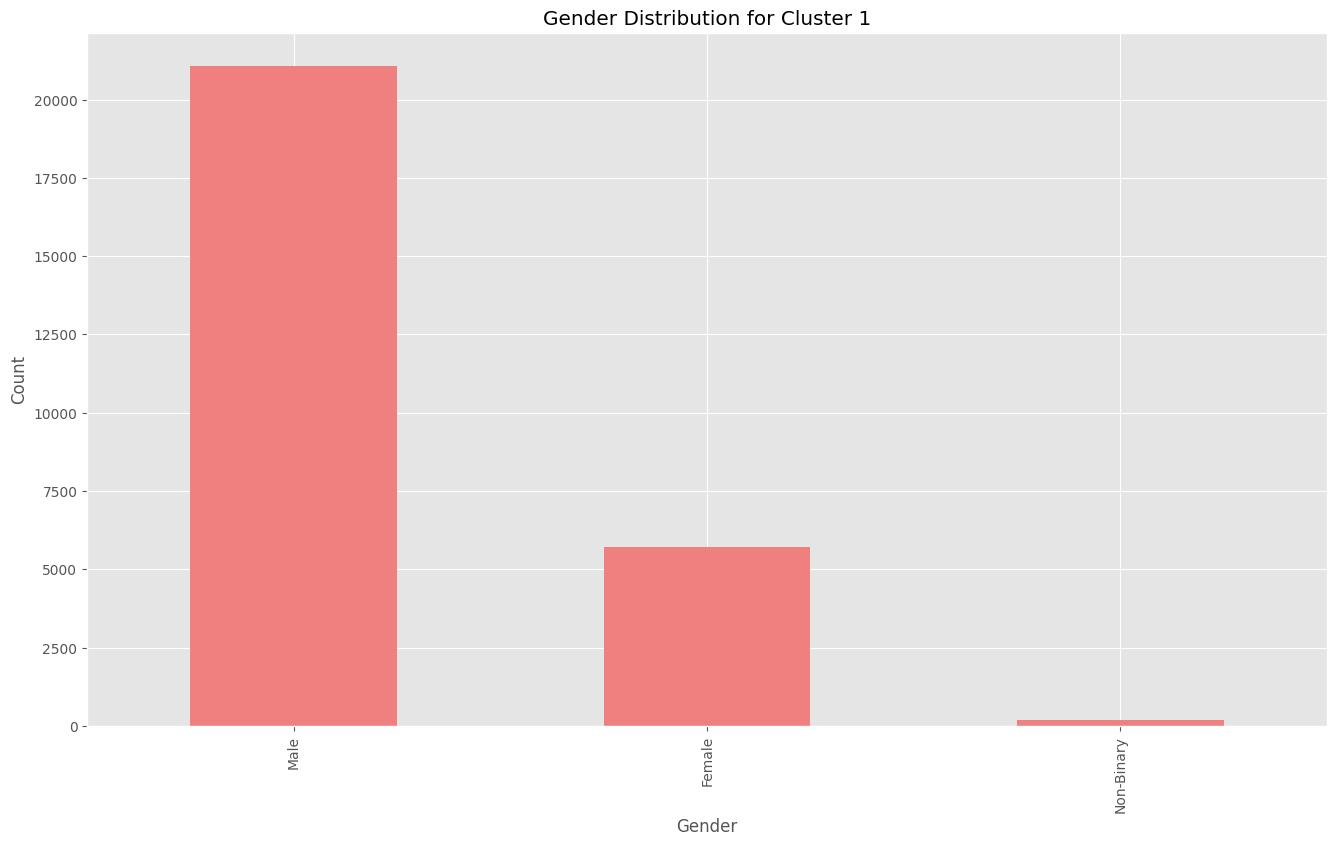

In [65]:
# Calculate gender distribution for cluster 1
gender_distribution_cluster_1 = cluster_1_users['gender'].value_counts()
print(gender_distribution_cluster_1)

# Plot gender distribution for cluster 1
gender_distribution_cluster_1.plot(kind='bar', color='lightcoral')
plt.title('Gender Distribution for Cluster 1')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


In [66]:
# Selecting relevant columns from the anime_with_mean_ratings DataFrame
data = anime_with_mean_ratings[['username', 'anime_id', 'user_id', 'my_score']]


In [30]:
# Checking if there are any duplicate rows
duplicated_rows = data[data.duplicated()]
print("Duplicated Rows:")
print(duplicated_rows)

Duplicated Rows:
Empty DataFrame
Columns: [username, anime_id, user_id, my_score]
Index: []


In [67]:
# Create a MinMaxScaler object
scaler = MinMaxScaler(feature_range=(0, 1))

# Normalize the 'my_score' column in the data, scaling its values between 0 and 1
data['scaled_score'] = scaler.fit_transform(data[['my_score']])

In [68]:
# Encoding user IDs
user_encoder = LabelEncoder()
data["user_encoded"] = user_encoder.fit_transform(data["user_id"])
num_users = len(user_encoder.classes_)

# Encoding anime IDs
anime_encoder = LabelEncoder()
data["anime_encoded"] = anime_encoder.fit_transform(data["anime_id"])
num_animes = len(anime_encoder.classes_)

# Printing dataset information
print("Number of unique users: {}".format(num_users))
print("Number of unique animes: {}".format(num_animes))
print("Minimum rating: {}".format(data['my_score'].min()))
print("Maximum rating: {}".format(data['my_score'].max()))

Number of unique users: 108710
Number of unique animes: 6668
Minimum rating: 0
Maximum rating: 10


In [69]:
# Shuffle the dataset
data = shuffle(data, random_state=272)

# Create feature matrix X and target variable y
X = data[['user_encoded', 'anime_encoded']].values
y = data["scaled_score"].values

# Printing dataset information
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (31284030, 2)
Shape of y: (31284030,)


In [70]:
# Define the number of samples to include in the test set
test_set_size = 10000

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_set_size, random_state=272)

# Printing the shapes of the resulting datasets
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (31274030, 2)
Shape of X_test: (10000, 2)
Shape of y_train: (31274030,)
Shape of y_test: (10000,)


In [71]:
# Define the RecommenderNet model
def RecommenderNet(num_users, num_animes, embedding_size=128):
    """
    Creates a neural network model for recommendations.
    
    Parameters:
    - num_users: int, number of unique users
    - num_animes: int, number of unique animes
    - embedding_size: int, size of the embedding vectors
    
    Returns:
    - model: compiled Keras model
    """
    # User input layer and embedding layer
    user = Input(name='user_encoded', shape=[1])
    user_embedding = Embedding(name='user_embedding', input_dim=num_users, output_dim=embedding_size)(user)
    
    # Anime input layer and embedding layer
    anime = Input(name='anime_encoded', shape=[1])
    anime_embedding = Embedding(name='anime_embedding', input_dim=num_animes, output_dim=embedding_size)(anime)
    
    # Dot product of user and anime embeddings
    dot_product = Dot(name='dot_product', normalize=True, axes=2)([user_embedding, anime_embedding])
    flattened = Flatten()(dot_product)
    
    # Dense layers for prediction
    dense = Dense(64, activation='relu')(flattened)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create and compile the model
    model = Model(inputs=[user, anime], outputs=output)
    model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['mae', 'mse'])
    
    return model

# Create the RecommenderNet model
model = RecommenderNet(num_users, num_animes)

# Display the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_encoded (InputLayer)   [(None, 1)]                  0         []                            
                                                                                                  
 anime_encoded (InputLayer)  [(None, 1)]                  0         []                            
                                                                                                  
 user_embedding (Embedding)  (None, 1, 128)               1391488   ['user_encoded[0][0]']        
                                                          0                                       
                                                                                                  
 anime_embedding (Embedding  (None, 1, 128)               853504    ['anime_encoded[0][0]'] 

In [72]:
# Import necessary callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping

# Define learning rate parameters and batch size
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

# Define the number of epochs for ramp-up, sustain, and exponential decay
rampup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

# Learning rate schedule function
def lrfn(epoch):
    if epoch < rampup_epochs:
        return (max_lr - start_lr) / rampup_epochs * epoch + start_lr
    elif epoch < rampup_epochs + sustain_epochs:
        return max_lr
    else:
        return (max_lr - min_lr) * exp_decay**(epoch - rampup_epochs - sustain_epochs) + min_lr

# Learning rate scheduler callback
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)

# File path for saving the model weights
checkpoint_filepath = 'weights.txt'

# Model checkpoint callback to save the best weights
model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath,
                                   save_weights_only=True,
                                   monitor='val_loss',
                                   mode='min',
                                   save_best_only=True)

# Early stopping callback to prevent overfitting
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)

# Define the list of callbacks
my_callbacks = [
    model_checkpoint,
    lr_callback,
    early_stopping
]


In [73]:
# Prepare input data for model training and evaluation
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

# Model training
history = model.fit(
    x=X_train_array,
    y=y_train,
    batch_size=batch_size,
    epochs=20,
    verbose=1,
    validation_data=(X_test_array, y_test),
    callbacks=my_callbacks
)

# Load the best weights saved during training
model.load_weights(checkpoint_filepath)

Epoch 1/20
3128/3128 [==============================] - 155s 49ms/step - loss: 0.6915 - mae: 0.3666 - mse: 0.1549 - val_loss: 0.6904 - val_mae: 0.3683 - val_mse: 0.1543 - lr: 1.0000e-05
Epoch 2/20
3128/3128 [==============================] - 150s 48ms/step - loss: 0.6907 - mae: 0.3692 - mse: 0.1546 - val_loss: 0.6904 - val_mae: 0.3686 - val_mse: 0.1542 - lr: 1.8000e-05
Epoch 3/20
3128/3128 [==============================] - 150s 48ms/step - loss: 0.6903 - mae: 0.3688 - mse: 0.1544 - val_loss: 0.6903 - val_mae: 0.3684 - val_mse: 0.1542 - lr: 2.6000e-05
Epoch 4/20
3128/3128 [==============================] - 151s 48ms/step - loss: 0.6699 - mae: 0.3503 - mse: 0.1445 - val_loss: 0.6328 - val_mae: 0.3136 - val_mse: 0.1269 - lr: 3.4000e-05
Epoch 5/20
3128/3128 [==============================] - 150s 48ms/step - loss: 0.5931 - mae: 0.2775 - mse: 0.1100 - val_loss: 0.5882 - val_mae: 0.2688 - val_mse: 0.1084 - lr: 4.2000e-05
Epoch 6/20
3128/3128 [==============================] - 151s 48ms/step

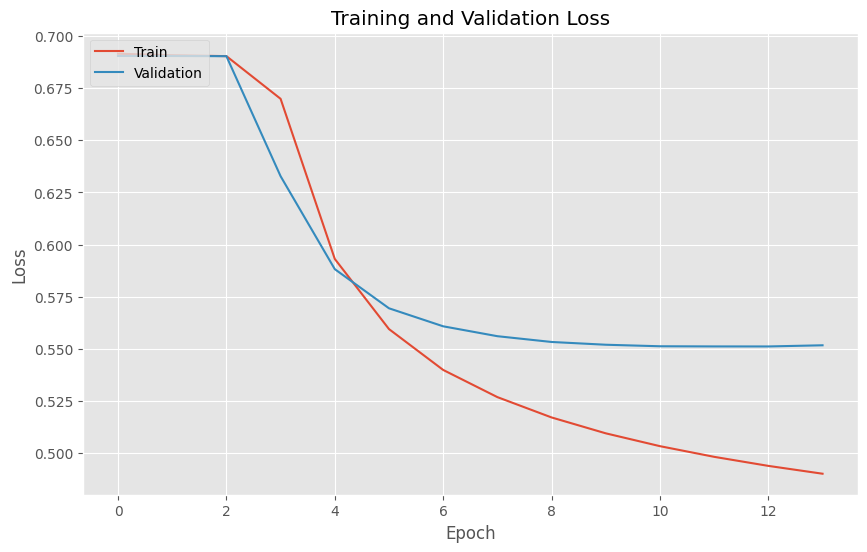

In [74]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history["loss"][:-2], label="Train")
plt.plot(history.history["val_loss"][:-2], label="Validation")
plt.title("Training and Validation Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(loc="upper left")
plt.show()

In [75]:
def extract_weights(name, model):
    """
    Extracts and normalizes the weights from a specified layer of the model.
    
    Parameters:
    - name: str, name of the layer from which to extract weights
    - model: Keras model, the model containing the layer
    
    Returns:
    - weights: np.array, normalized weights from the specified layer
    """
    # Get the layer by name from the model
    weight_layer = model.get_layer(name)
    
    # Get the weights from the layer
    weights = weight_layer.get_weights()[0]
    
    # Normalize the weights
    weights = weights / np.linalg.norm(weights, axis=1).reshape((-1, 1))
    
    return weights

# Extract weights for anime embeddings
anime_weights = extract_weights('anime_embedding', model)

# Extract weights for user embeddings
user_weights = extract_weights('user_embedding', model)


In [76]:
# Create a copy of the anime_data DataFrame
df_anime = anime_data.copy()

In [78]:
def find_similar_animes(name, n=10, neg=False):
    """
    Finds similar animes based on the specified anime name.
    
    Parameters:
    - name: str, name of the anime to find similarities for
    - n: int, number of similar animes to return (default is 10)
    - neg: bool, if True, returns the least similar animes (default is False)
    
    Returns:
    - DataFrame: containing similar animes with their titles, English titles, genres, and similarity scores
    """
    try:
        # Find the anime row based on title or English title
        anime_row = df_anime[(df_anime['title'] == name) | (df_anime['title_english'] == name)].iloc[0]
        index = anime_row['anime_id']
        encoded_index = anime_encoder.transform([index])[0]
        
        # Calculate distances using dot product of weights
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        
        n = n + 1
        if neg:
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        
        print('Animes closest to {}'.format(name))
        
        # Prepare the similarity results
        similarity_arr = []
        for close in closest:
            decoded_id = anime_encoder.inverse_transform([close])[0]
            anime_frame = df_anime[df_anime['anime_id'] == decoded_id]
            
            anime_name = anime_frame['title'].values[0]
            english_title = anime_frame['title_english'].values[0]
            genre = anime_frame['genre'].values[0]
            similarity = dists[close]
            similarity = "{:.2f}%".format(similarity * 100)
            similarity_arr.append({
                "Name": anime_name,
                "English Title": english_title,
                "Similarity": similarity,
                "Genres": genre
            })
        
        result_frame = pd.DataFrame(similarity_arr).sort_values(by="Similarity", ascending=False)
        return result_frame[result_frame.Name != name]
    except Exception as e:
        print(f'{name} not found in Anime list. Error: {e}')

# Set display option for pandas
pd.set_option('display.max_colwidth', None)

In [79]:
# Function to handle button click event
def recommend_animes():
    anime_name = entry.get()
    if anime_name:
        recommended_animes = find_similar_animes(anime_name)
        html_table = recommended_animes.to_html(index=False)
        html_label = HTMLLabel(window, html=html_table)
        html_label.pack()

# Create the main window
window = tk.Tk()
window.title("Anime Recommender")

# Create a label
label = tk.Label(window, text="Enter an anime name:")
label.pack()

# Create an entry field
entry = tk.Entry(window)
entry.pack()

# Create a button
button = tk.Button(window, text="Recommend", command=recommend_animes)
button.pack()

# Run the main loop
window.mainloop()

Animes closest to Attack on Titan


In [80]:
# Testing the functionality of the recommender system
test_anime_name = "Naruto"
recommended_animes = find_similar_animes(test_anime_name, n=10, neg=False)

# Display the recommended animes
if recommended_animes is not None:
    print(recommended_animes)
else:
    print(f"No recommendations found for {test_anime_name}")

Animes closest to Naruto
                                 Name                         English Title Similarity                                                                  Genres
9                  Naruto: Shippuuden                     Naruto: Shippuden     90.84%           Action, Adventure, Comedy, Super Power, Martial Arts, Shounen
8                       Dragon Ball Z                         Dragon Ball Z     82.24%  Action, Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
7                              Bleach                                Bleach     80.88%           Action, Adventure, Comedy, Super Power, Supernatural, Shounen
6                          Death Note                            Death Note     79.59%         Mystery, Police, Psychological, Supernatural, Thriller, Shounen
5                         Dragon Ball                           Dragon Ball     75.42%          Adventure, Comedy, Fantasy, Martial Arts, Shounen, Super Power
4  Final Fantasy VII: